In [1]:
import yt
import numpy as np
import trident
import matplotlib.pyplot as pl
from yt.units import kpc,mp
from yt.fields.particle_fields import add_volume_weighted_smoothed_field

In [2]:
%%time
fname = '/mnt/raid-project/murray/lakhlani/FIRE2_core/m12c_res56000/output/snapshot_600.hdf5'
ds = yt.load(fname)
center_Halo = [25277.66673046,34505.21241664,32868.48520185]
sp = ds.sphere(center_Halo, (10, "kpc"))
ang_mom_sphere = ds.sphere(center_Halo, (0.5, "kpc"))

yt : [INFO     ] 2020-05-15 13:54:18,965 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2020-05-15 13:54:18,966 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2020-05-15 13:54:19,018 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2020-05-15 13:54:19,019 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-05-15 13:54:19,020 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-05-15 13:54:19,022 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2020-05-15 13:54:19,024 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05-15 13:54:19,025 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2020-05-15 13:54:19,025 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2020-05-15 13:54:19,026 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2020-05-15 13:54:19,028 Parameters: omega_radiation           = 0.

CPU times: user 12 s, sys: 2.5 s, total: 14.5 s
Wall time: 14.5 s


In [3]:
# angular_momentum =[np.mean(ang_mom_sphere['angular_momentum_x']),
#                    np.mean(ang_mom_sphere['angular_momentum_y']),
#                    np.mean(ang_mom_sphere['angular_momentum_z'])]
# normalized_ang = np.array(angular_momentum)/angular_momentum[0]
# print(normalized_ang)

In [4]:
perp = np.array([1.,-0.23746973,-0.36259271])
parr = np.array([1,1,2.10299393498])
norm_perp = tuple(perp/np.linalg.norm(perp))
norm_parr = tuple(parr/np.linalg.norm(parr))

In [5]:
def _ElectronDensity(field, data):
    xh= 1. - data['PartType0','Metallicity_00'] - data['PartType0','Metallicity_01']
    ne= xh * data['PartType0','Density'] * data['PartType0','ElectronAbundance'] / mp
    return ne

ds.add_field(('PartType0', '_ElectronDensity'), function = _ElectronDensity, 
             sampling_type = 'particle', units='1/cm**3')

fn = add_volume_weighted_smoothed_field(
      "PartType0", "particle_position", "particle_mass", "smoothing_length",
      "density", "_ElectronDensity",ds.field_info)

ds.field_info.alias(('gas', '_ElectronDensity'), fn[0])
ds.derived_field_list.append(('gas', '_ElectronDensity'))


In [6]:
def make_ray_plots(perp, parr, filename, all_angles = False):
    # RAY CREATION
    ray_end = list(np.array(center_Halo) + 4*np.array(parr))
    ray = trident.make_simple_ray(ds,
                                   start_position=center_Halo,
                                    end_position=ray_end,
                                    fields = ['_ElectronDensity','density','temperature'],
                                    data_filename="ray_disc.h5")
    
    # GALAXY PLOTS
    if all_angles:
        prj_x = yt.ProjectionPlot(ds, 'x', 'density', width=5*kpc, data_source = sp,
                                  center=center_Halo)
        prj_x.annotate_ray(ray)
        prj_x.save(filename+'_galaxy_x.pdf')
        
        prj_y = yt.ProjectionPlot(ds, 'y', 'density', width=5*kpc, data_source = sp,
                                  center=center_Halo)
        prj_y.annotate_ray(ray)
        prj_y.save(filename+'_galaxy_y.pdf')
        
        prj_z = yt.ProjectionPlot(ds, 'z', 'density', width=5*kpc, data_source = sp,
                                  center=center_Halo)
        prj_z.annotate_ray(ray)
        prj_z.save(filename+'_galaxy_z.pdf')
        

        
    else:
        image = yt.OffAxisProjectionPlot(ds, perp, fields= 'density', center= center_Halo, 
                                     width=5, data_source = sp)
        image.annotate_ray(ray)
        image.save(filename+'_galaxy.pdf')
    
        # COMPUTING THE DM
        length = np.linalg.norm(np.array(center_Halo)-np.array(ray_end))
        int_elec_dens = []
        int_total = 0
        increment = length*/len(ray.data['_ElectronDensity'])
        for i in range(len(ray.data['_ElectronDensity'])):
            int_total += ray.data['_ElectronDensity'][i]*increment
            int_elec_dens.append(float(int_total))
        
        # LIGHT RAY DATA PLOTS
        fig, axs = pl.subplots(2,2)

        axs[0,0].plot(np.linspace(0,length,len(ray.data['density'])), 
                      np.log10(ray.data['density']))
        axs[0,0].set_xlabel('Arc Length (kpc)')
        axs[0,0].set_ylabel('Density '+r'$\log\left(\frac{g}{cm^3}\right)$')

        axs[0,1].plot(np.linspace(0,length,len(ray.data['temperature'])), 
                      np.log10(ray.data['temperature']))
        axs[0,1].set_xlabel('Arc Length (kpc)')
        axs[0,1].set_ylabel('Temperature '+r'$\log(K)$')

        axs[1,0].plot(np.linspace(0,length,len(ray.data['_ElectronDensity'])), 
                np.log10(ray.data['_ElectronDensity']))
        axs[1,0].set_xlabel('Arc Length (kpc)')
        axs[1,0].set_ylabel('Electron Density '+r'$\log(cm^{-3})$')

        axs[1,1].plot(np.linspace(0,length,len(ray.data['_ElectronDensity'])), 
                      np.log10(int_elec_dens))
        axs[1,1].set_xlabel('Arc Length (kpc)')
        axs[1,1].set_ylabel('Dispersion Measure '+r'$\log(cm^{-2})$')

        pl.subplots_adjust(left = 0.12,right = 0.9,bottom = 0.2,top = 0.9,
                           wspace = 0.4,hspace = 0.8)
        fig.savefig(filename+'_subplots.pdf')

yt : [INFO     ] 2020-05-15 13:54:33,474 Getting segment at z = 0.0: [0.42129445 0.57508687 0.54780809] unitary to [0.42132075 0.57511318 0.54786341] unitary.
yt : [INFO     ] 2020-05-15 13:54:33,477 Getting subsegment: [0.4212944455076667 unitary, 0.5750868736106668 unitary, 0.5478080866975 unitary] to [0.4213207514498732 unitary, 0.5751131795528732 unitary, 0.5478634079344141 unitary].
yt : [INFO     ] 2020-05-15 13:58:36,138 Saving field data to yt dataset: ray_disc.h5.
yt : [INFO     ] 2020-05-15 13:58:36,479 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2020-05-15 13:58:36,481 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-05-15 13:58:36,482 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2020-05-15 13:58:36,483 Parameters: domain_right_edge         = [60000. 60000. 60000.] code_length
yt : [INFO     ] 2020-05-15 13:58:36,484 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05

yt : [INFO     ] 2020-05-15 13:59:53,169 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,192 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,220 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,236 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,257 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,278 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,300 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,322 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,345 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,363 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,379 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,395 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 13:59:53,417 Returning a

CPU times: user 3min 34s, sys: 1min 46s, total: 5min 20s
Wall time: 5min 21s


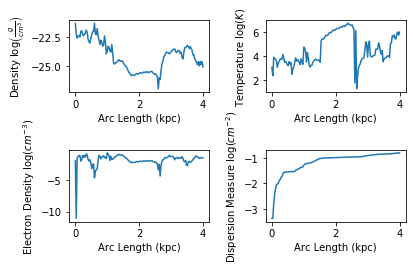

In [7]:
%%time
make_ray_plots(norm_perp, norm_parr, 'ray_parr')

yt : [INFO     ] 2020-05-15 13:59:55,910 Getting segment at z = 0.0: [0.42129445 0.57508687 0.54780809] unitary to [0.42135561 0.57507235 0.54778591] unitary.
yt : [INFO     ] 2020-05-15 13:59:55,913 Getting subsegment: [0.4212944455076667 unitary, 0.5750868736106668 unitary, 0.5478080866975 unitary] to [0.4213556136279367 unitary, 0.5750723480336616 unitary, 0.5477859075830057 unitary].
yt : [INFO     ] 2020-05-15 14:03:45,915 Saving field data to yt dataset: ray_disc.h5.
yt : [INFO     ] 2020-05-15 14:03:46,279 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2020-05-15 14:03:46,280 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-05-15 14:03:46,281 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2020-05-15 14:03:46,283 Parameters: domain_right_edge         = [60000. 60000. 60000.] code_length
yt : [INFO     ] 2020-05-15 14:03:46,284 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05

yt : [INFO     ] 2020-05-15 14:05:18,223 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,238 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,259 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,279 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,300 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,322 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,346 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,362 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,381 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,513 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,534 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,556 Returning an all_data data container.
yt : [INFO     ] 2020-05-15 14:05:18,581 Returning a

CPU times: user 3min 39s, sys: 1min 43s, total: 5min 22s
Wall time: 5min 23s


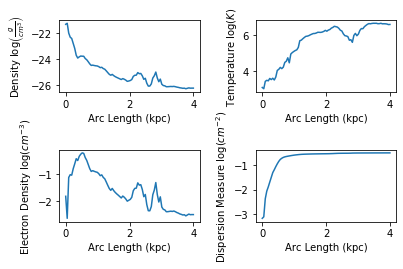

In [8]:
%%time
make_ray_plots(norm_parr, norm_perp, 'ray_perp')